# TLS Version Distribution Analysis

This notebook analyzes the distribution of TLS versions from the dataset in `data/tls_features.parquet`. We filter out domains where the connection was not successful (`connect_ok` is false) and visualize the distribution using a donut chart.


In [113]:
import duckdb

import matplotlib.pyplot as plt
import os

file_path = '../data/data_com/com_tls_features.parquet'
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"Error: File not found: {file_path}")


File found: ../data/data_com/com_tls_features.parquet


In [114]:

con = duckdb.connect(database=':memory:')

schema_query = f"""DESCRIBE SELECT * FROM '{file_path}'"""
schema_df = con.execute(schema_query).fetchdf()
print("Schema of the parquet file:")
display(schema_df)

preview_query = f"""SELECT * FROM '{file_path}' LIMIT 5"""
preview_df = con.execute(preview_query).fetchdf()
print("\nPreview of the data:")
display(preview_df)


Schema of the parquet file:


,column_name,column_type,null,key,default,extra
0,visit_id,VARCHAR,YES,None,None,None
1,domain_name,VARCHAR,YES,None,None,None
2,host_name,VARCHAR,YES,None,None,None
3,host_name_matches_certificate,BOOLEAN,YES,None,None,None
4,chain_trusted_by_java_platform,BOOLEAN,YES,None,None,None
5,certificate_expired,BOOLEAN,YES,None,None,None
6,certificate_too_soon,BOOLEAN,YES,None,None,None
7,crawl_timestamp,DOUBLE,YES,None,None,None
8,scan_timestamp,DOUBLE,YES,None,None,None
9,ip,VARCHAR,YES,None,None,None



Preview of the data:


,visit_id,domain_name,host_name,host_name_matches_certificate,chain_trusted_by_java_platform,certificate_expired,certificate_too_soon,crawl_timestamp,scan_timestamp,ip,...,error_tls_1_0,error_ssl_3_0,error_ssl_2_0,millis_tls_1_3,millis_tls_1_2,millis_tls_1_1,millis_tls_1_0,millis_ssl_3_0,millis_ssl_2_0,certificate_chain_fingerprints
0,5481911,0033k.cc,0033k.cc,True,True,False,False,1.747117e+09,1.747117e+09,156.236.188.71,...,(protocol_version) Received fatal alert: proto...,(handshake_failure) Received fatal alert: hand...,None,338,4183,692,326,343,343,[47f2c9e08a95300ffb9d024fe1e73e4aa44bf88340873...
1,5481911,0033k.cc,www.0033k.cc,False,True,False,False,1.747117e+09,1.747117e+09,156.236.187.142,...,(protocol_version) Received fatal alert: proto...,(handshake_failure) Received fatal alert: hand...,None,344,4205,701,321,330,348,[e056d7efd113a4a0e9fc61fa31e12bcf44653729a5f4d...
2,5483566,2244k.cc,2244k.cc,False,False,False,False,1.747117e+09,1.747117e+09,None,...,Unknown host,Unknown host,Unknown host,0,0,0,0,0,0,[]
3,5483566,2244k.cc,www.2244k.cc,False,False,False,False,1.747117e+09,1.747117e+09,None,...,Unknown host,Unknown host,Unknown host,0,0,0,0,0,0,[]
4,5861472,adcdzj0rbm.cc,adcdzj0rbm.cc,False,False,False,False,1.747118e+09,1.747118e+09,None,...,Unknown host,Unknown host,Unknown host,0,0,0,0,0,0,[]


## Analyzing TLS Version Distribution

Now we'll analyze the distribution of TLS versions, filtering out domains where the connection was not successful (connect_ok is false).


In [115]:
subquery = f"""
SELECT high, low, count(1) as count from
    (SELECT visit_id, domain_name, max(highest_version_supported) as high, max(lowest_version_supported) as low
    FROM '{file_path}'
    where connect_ok
    and highest_version_supported is not Null
    and lowest_version_supported is not NUll
    is True group by visit_id, domain_name) group by high, low
"""
result_df = con.execute(subquery).fetchdf()
display(result_df)



,high,low,count
0,TLSv1.2,TLSv1.2,44
1,TLSv1.3,TLSv1.1,133
2,TLSv1.3,TLSv1,425
3,TLSv1.1,TLSv1,1
4,TLSv1.2,SSLv3,2
5,TLSv1.2,TLSv1,93
6,TLSv1,SSLv2,1
7,TLSv1.2,TLSv1.1,2
8,TLSv1.3,TLSv1.3,15
9,TLSv1.3,TLSv1.2,243


In [116]:
query = f"""
SELECT high, sum(count) as count FROM (SELECT high, low, count(1) as count from
    (SELECT visit_id, domain_name, max(highest_version_supported) as high, max(lowest_version_supported) as low
    FROM '{file_path}'
    where connect_ok
    and highest_version_supported is not Null
    and lowest_version_supported is not NUll
    is True group by visit_id, domain_name) group by high, low)
    group by high order by high
"""
result_df = con.execute(query).fetchdf()
display(result_df)


,high,count
0,TLSv1,1.0
1,TLSv1.1,1.0
2,TLSv1.2,141.0
3,TLSv1.3,816.0


## Visualizing TLS Version Distribution

Now we'll create a visualization of the TLS version distribution using a donut chart.


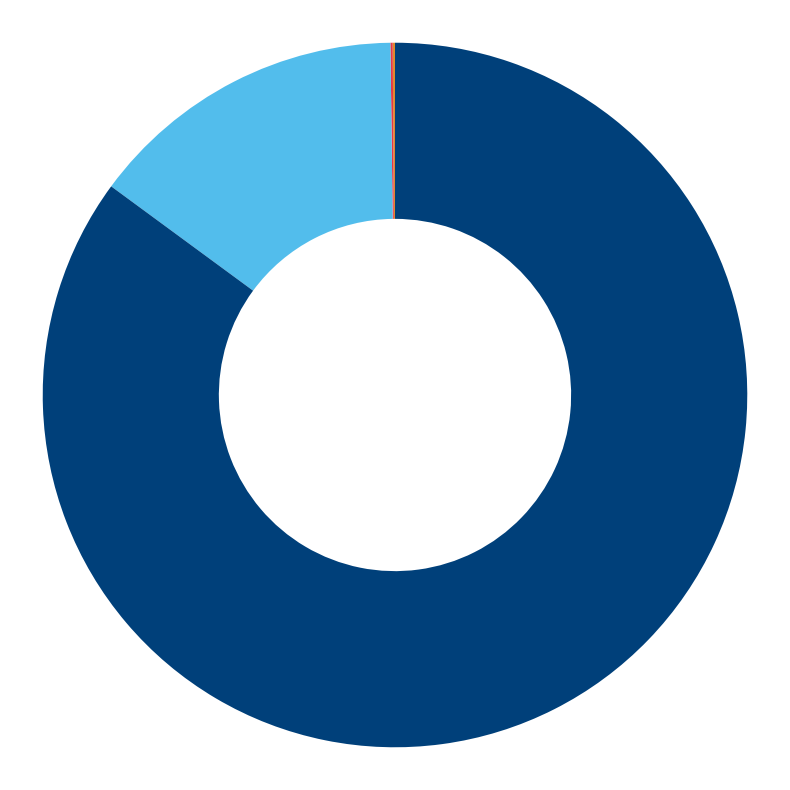


TLS Version Distribution Summary:


,high,count
0,TLSv1,1.0
1,TLSv1.1,1.0
2,TLSv1.2,141.0
3,TLSv1.3,816.0


In [117]:
if 'result_df' in locals():
    # Set up the figure with one subplot
    fig, ax1 = plt.subplots(1, 1, figsize=(8,8))

    # Donut Chart
    # Create custom legend labels with percentages
    legend_labels = [f"{row['high']} ({row['count']})" for _, row in result_df.iterrows()]

    # Remove autopct to not show percentages on the chart
    ax1.pie(result_df['count'], labels=None, startangle=90, shadow=False, 
           colors=["#DD8A2E", "#E63946","#52BDEC", "#00407A",  "#000000"],
           wedgeprops=dict(width=0.5))

    ax1.axis('equal')
    # ax1.legend(legend_labels, loc='upper right')

    plt.tight_layout()
    plt.show()

    # Display the results in a table
    print("\nTLS Version Distribution Summary:")
    display(result_df)
else:
    print("No valid results available for visualization. Please adjust the queries based on the actual schema.")
